In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
import random
from time import time

C:\Users\Max\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def prepare_data(mode):
    """ divides data into images and labels
        Min-Max scales images
    Params:
        mode : String (either "padded" or "resized")
    Returns:
        scaled_X : array with images
        y : array with corresponding labels
        (0 for non-IDC, 1 for IDC)
    """
    patches = glob.glob('./' + mode + '/*.png')
    X = []
    y = []
    for img_name in patches:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name.endswith('class0.png') else y.append(1)
    scaled_X = np.array(X)/255.0
    return scaled_X, y

In [3]:
def create_CNN():
    input_shape = (50, 50, 3)
    num_classes = 2
    reg = 0.0001
    
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [6]:
cnn_pad = create_CNN()
cnn_pad.summary()
#plot_model(cnn_pad, to_file='simple_cnn_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
__________

In [7]:
X_pad, y = prepare_data("padded")

print(X_pad.shape)
print(y.count(1))
print(y.count(0))

(277524, 50, 50, 3)
78786
198738


In [7]:
def balance(X, y):
    """ Function for getting perfectly balanced data set (50/50)
        Takes as many negative examples, as there are positive ones
        DON'T USE IT IF YOUR DATASET IS OK
    """
    X0 = []
    X1 = []
    for i in range(0, len(y)):
        X1.append(X[i]) if y[i] == 1 else X0.append(X[i]) 
        X0 = np.array(X0)
        X1 = np.array(X1)
    
    random.shuffle(X0)
    balanced_X0 = X0[:len(X1)] 
    X_balanced = np.concatenate((balanced_X0, X1))

    a = [0] * len(balanced_X0) 
    b = [1] * len(X1)
    y_balanced = a + b

    return X_balanced, y_balanced
    
#X_pad, y = balance(X_pad, y)

In [8]:
X_train_tune, X_test, y_train_tune, y_test = train_test_split(X_pad, y, test_size=0.1, random_state=42)

y_train_tune_onehot = np_utils.to_categorical(y_train_tune, 2)
y_test_onehot = np_utils.to_categorical(y_test, 2)

epochs = 20
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=1, batch_size=batch_size, 
                          write_grads=True, write_images=True)

fit_history = cnn_pad.fit(X_train_tune, y_train_tune_onehot,
                      batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      verbose=1, validation_split=0.1, callbacks=[early_stopping, tensorboard])

Train on 224793 samples, validate on 24978 samples
Epoch 1/20
224793/224793 [==============================] - 775s 3ms/step - loss: 0.4321 - acc: 0.8467 - val_loss: 0.4445 - val_acc: 0.8276
Epoch 2/20
224793/224793 [==============================] - 635s 3ms/step - loss: 0.3646 - acc: 0.8628 - val_loss: 0.4201 - val_acc: 0.8459
Epoch 3/20
224793/224793 [==============================] - 600s 3ms/step - loss: 0.3528 - acc: 0.8704 - val_loss: 0.6423 - val_acc: 0.7969
Epoch 4/20
224793/224793 [==============================] - 580s 3ms/step - loss: 0.3454 - acc: 0.8743 - val_loss: 1.2461 - val_acc: 0.7245
Epoch 5/20
224793/224793 [==============================] - 621s 3ms/step - loss: 0.3359 - acc: 0.8773 - val_loss: 1.8128 - val_acc: 0.7179
Epoch 6/20
224793/224793 [==============================] - 571s 3ms/step - loss: 0.3310 - acc: 0.8802 - val_loss: 1.2603 - val_acc: 0.7358
Epoch 7/20
224793/224793 [==============================] - 554s 2ms/step - loss: 0.3241 - acc: 0.8813 - val_

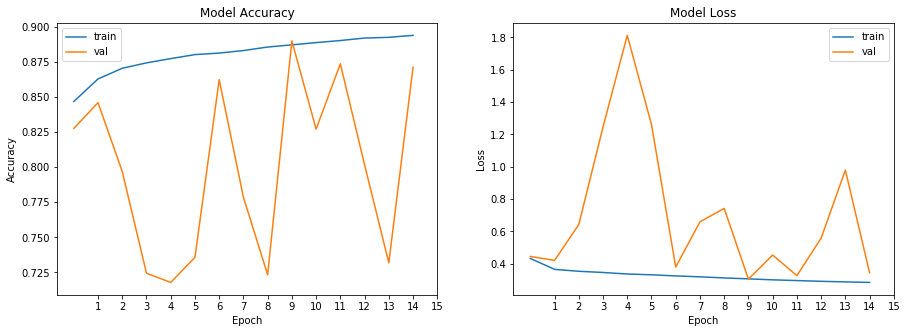

In [9]:
def plot_history(history):
    """ Util function for plotting model's accuracy and loss
        Actually it can be deleted since all this info is in Tensorboard
        Go for it 
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_xticks(np.arange(1, len(history.history['acc'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_history(fit_history)

In [ ]:
#score_pad = cnn_pad.evaluate(X_test, y_test_onehot, verbose=0)
#print('Test loss:', score_pad[0])
#print('Test accuracy:', score_pad[1])

#plt.plot(fit_history.history['loss'])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Simple CNN with padded imgs')
#plt.show()